# How to Benchmark Optimization Algorithms

Benchmarking optimization algorithms is an important step when developing a new algorithm or when searching for an algorithm that is good at solving a particular problem. 

In general, benchmarking constists of the following steps:

1. Define the test problems (or get pre-implemented ones)
2. Define the optimization algorithms and the tuning parameters you want to try
3. Run the benchmark
4. Plot the results

Estimagic helps you with all of these steps!

## 1. Get Test Problems

Estimagic includes the problems of [Moré and Wild (2009)](https://doi.org/10.1137/080724083) as well as [Cartis and Roberts](https://arxiv.org/abs/1710.11005).

Each problem consist of the `inputs` (the criterion function and the start parameters) and the `solution` (the optimal parameters and criterion value) and optionally provides more information.

Below we load a subset of the Moré and Wild problems and look at one particular Rosenbrock problem that has difficult start parameters.

In [1]:
import estimagic as em

In [2]:
problems = em.get_benchmark_problems("example")

## 2. Specify the Optimizers

To select optimizers you want to benchmark on the set of problems, you can simply specify them as a list. Advanced examples - that do not only compare algorithms but also vary the `algo_options` - can be found below. 

In [3]:
optimizers = [
    "nag_dfols",
    "scipy_neldermead",
    "scipy_truncated_newton",
]

## 3. Run the Benchmark

Once you have your problems and your optimizers set up, you can simply use `run_benchmark`. The results are a dictionary with one entry for each (problem, algorithm) combination. Each entry not only saves the solution but also the history of the algorithm's criterion and parameter history. 

In [4]:
results = em.run_benchmark(
    problems,
    optimizers,
)

## 4a. Profile plots

**Profile Plots** compare optimizers over a whole problem set. 

The literature distinguishes **data profiles** and **performance profiles**. Data profiles use a normalized runtime measure whereas performance profiles use an absolute one. The profile plot does not normalize runtime by default. To do this, simply set `normalize_runtime` to True. For background information, check [Moré and Wild (2009)](https://doi.org/10.1137/080724083). 

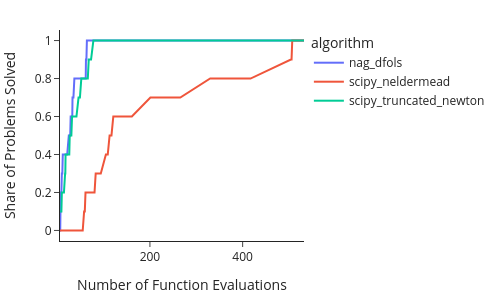

In [5]:
fig = em.profile_plot(
    problems=problems,
    results=results,
)

fig.show(renderer="png")

The x axis shows runtime per problem. The y axis shows the share of problems each algorithm solved within that runtime. Thus, higher and further to the left values are desirable. Higher means more problems were solved and further to the left means, the algorithm found the solutions earlier. 

You can choose:

- whether to use `n_evaluations` or `walltime` as **`runtime_measure`**
- whether to normalize runtime such that the runtime of each problem is shown as a multiple of the fastest algorithm on that problem
- how to determine when an evaluation is close enough to the optimum to be counted as converged. Convergence is always based on some measure of distance between the true solution and the solution found by an optimizer. Whether distiance is measured in parameter space, function space, or a combination of both can be specified. 

Below, we consider a problem to be solved if the distance between the parameters found by the optimizer and the true solution parameters are at most 0.1% of the distance between the start parameters and true solution parameters. 

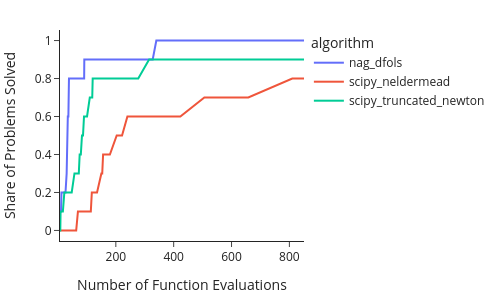

In [6]:
fig = em.profile_plot(
    problems=problems,
    results=results,
    runtime_measure="n_evaluations",
    stopping_criterion="x",
    x_precision=0.001,
)

fig.show(renderer="png")

## 4b. Convergence plots

**Convergence Plots** look at particular problems and show the convergence of each optimizer on each problem. They look similar to what you've seen from estimagic's dashboard.

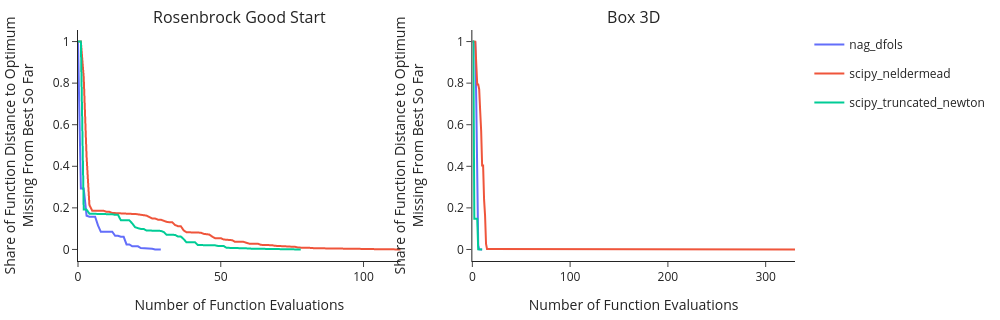

In [7]:
fig = em.convergence_plot(
    problems=problems,
    results=results,
    n_cols=2,
    problem_subset=["rosenbrock_good_start", "box_3d"],
)

fig.show(renderer="png")

The further to the left and the lower the curve of an algorithm, the better that algorithm performed.

Often we are more interested in how close each algorithm got to the true solution in parameter space, not in criterion space as above. For this. we simply set the **`distance_measure`** to `parameter_space`. 

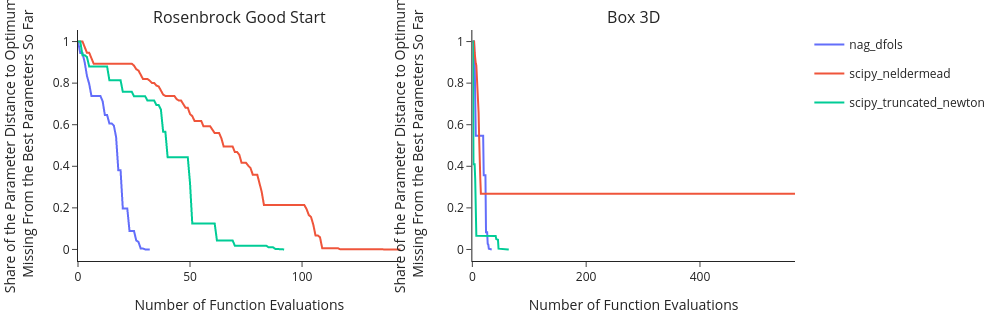

In [8]:
fig = em.convergence_plot(
    problems=problems,
    results=results,
    n_cols=2,
    problem_subset=["rosenbrock_good_start", "box_3d"],
    distance_measure="parameter_distance",
    stopping_criterion="x",
)

fig.show(renderer="png")

## 5a. Convergence report

The **Convergence Report** shows for each problem and optimizer which problems the optimizer solved successfully, failed to do so, or where it stopped with an error. The respective strings are "success", "failed", or "error".
Moreover, the last column of the ```pd.DataFrame``` displays the number of dimensions of the benchmark problem.

In [9]:
df = em.convergence_report(
    problems=problems,
    results=results,
    stopping_criterion="y",
    x_precision=1e-4,
    y_precision=1e-4,
)

In [10]:
df

,nag_dfols,scipy_neldermead,scipy_truncated_newton,dimensionality
problem,,,,
bard_good_start,success,success,success,3
bdqrtic_8,success,success,success,8
box_3d,success,success,success,3
brown_dennis_good_start,success,success,success,4
chebyquad_6,success,success,success,6
freudenstein_roth_good_start,success,success,success,2
helical_valley_good_start,success,success,success,3
mancino_5_good_start,success,success,success,5
powell_singular_good_start,success,success,success,4


## 5b. Rank report¶

The **Rank Report** shows the ranks of the algorithms for each problem; where 0 means the algorithm was the fastest on a given benchmark problem, 1 means it was the second fastest and so on. If an algorithm did not converge on a problem, the value is "failed". If an algorithm did encounter an error during optimization, the value is "error".

In [11]:
df = em.rank_report(
    problems=problems,
    results=results,
    runtime_measure="n_evaluations",
    stopping_criterion="y",
    x_precision=1e-4,
    y_precision=1e-4,
)

In [12]:
df

algorithm,nag_dfols,scipy_neldermead,scipy_truncated_newton
problem,,,
bard_good_start,0,2,1
bdqrtic_8,1,2,0
box_3d,0,1,0
brown_dennis_good_start,1,2,0
chebyquad_6,0,2,1
freudenstein_roth_good_start,1,2,0
helical_valley_good_start,0,2,1
mancino_5_good_start,1,2,0
powell_singular_good_start,0,2,1


## 5b. Traceback report¶

The **Traceback Report** shows the tracebacks returned by the optimizers if they encountered an error during optimization. The resulting ```pd.DataFrame``` is empty if none of the optimizers terminated with an error, as in the example below.

In [13]:
df = em.traceback_report(results=results)

In [14]:
df

,scipy_neldermead,scipy_truncated_newton,nag_dfols
